In [1]:
!pip install missingno

In [2]:
!pip install tensorflow-addons
!pip install scikit-plot 

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [32]:
import pandas as pd     
import numpy as np     
import random as rnd    
import missingno as msno   
import matplotlib.pyplot as plt   
import seaborn as sns    #statistical data vis
import string as st     
import tensorflow as tf     
import scikitplot as skplt  

from tensorflow import keras                                         
from wordcloud import WordCloud, stopwords, ImageColorGenerator     
from sklearn.model_selection import train_test_split                              
from keras.preprocessing.text import Tokenizer                                    
from keras.preprocessing.sequence import pad_sequences                                 
from keras.optimizers import Adam                          #training optimizer                
from sklearn.metrics import confusion_matrix        #highlights accuracy and errors wherever(TP,TN,FP,FN)                      
from sklearn.metrics import accuracy_score, recall_score, precision_score 
from sklearn.metrics import classification_report                         

import warnings                   
warnings.filterwarnings('ignore') # set notifications to be ignored

# additional settings
## chart style
plt.style.use('ggplot')
sns.set_style('dark')

## set fixed random seed for reproducible results
seed = 123

tf.random.set_seed(seed)
np.random.seed(seed)
rnd.seed(seed)

# configure the output to show all columns
pd.options.display.max_columns  = None

# configure output of figures in 'svg' format (best quality)
%config InlineBackend.figure_format = 'svg'

ImportError: cannot import name 'interp' from 'scipy' (C:\Users\JoelAnaikah\anaconda3\Lib\site-packages\scipy\__init__.py)

In [6]:
data_path = r"C:\Users\JoelAnaikah\Downloads\train.csv"
df_raw = pd.read_csv(data_path)

In [8]:
df_raw.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [10]:
df_raw.tail()

,id,title,author,text,label
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1
20799,20799,What Keeps the F-35 Alive,David Swanson,"David Swanson is an author, activist, journa...",1


In [12]:
# check the data set size
print('Dataset Dimensions')
print('-' * 30)
print('Total records:\t\t {}'.format(df_raw.shape[0]))
print('Total attributes:\t {}'.format(df_raw.shape[1]))
df_raw.info()

Dataset Dimensions
------------------------------
Total records:		 20800
Total attributes:	 5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [14]:
print(((df_raw.isnull().sum() / df_raw.shape[0]) * 100).sort_values(ascending=False).round(2))


author    9.41
title     2.68
text      0.19
id        0.00
label     0.00
dtype: float64


<Axes: >

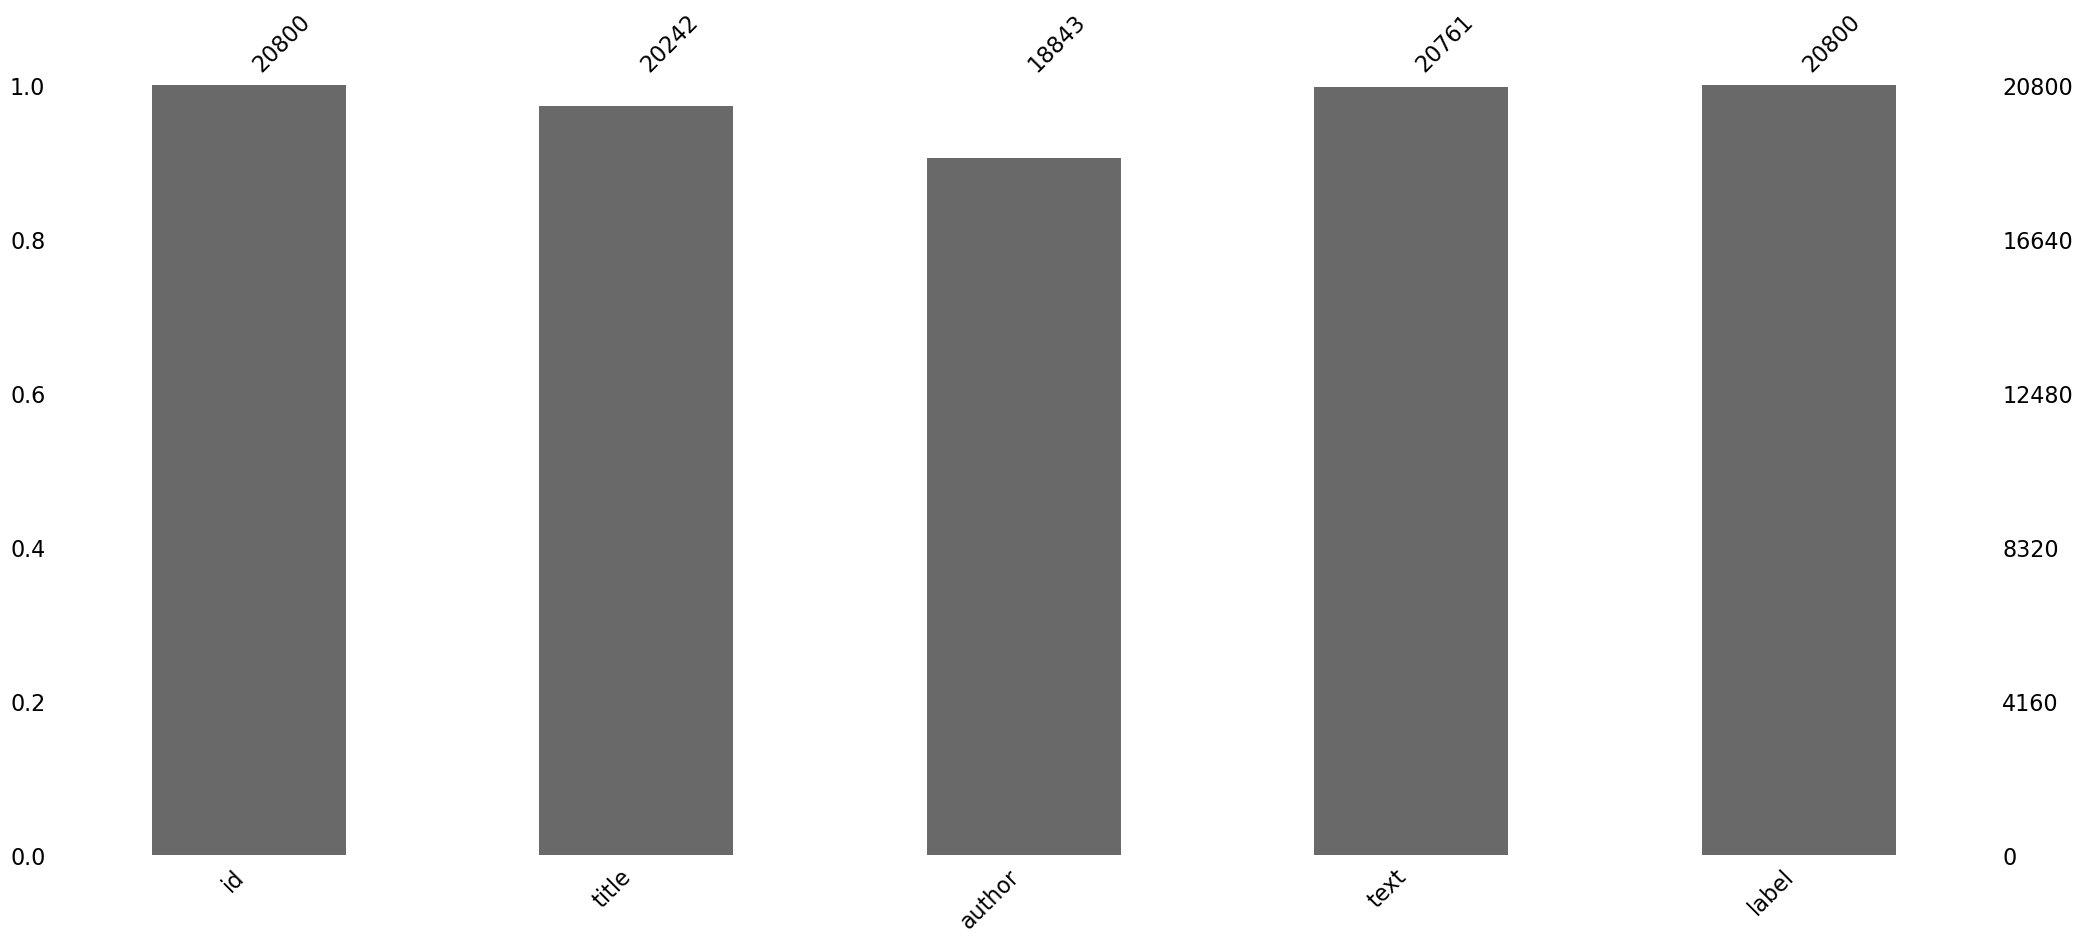

In [16]:
msno.bar(df_raw)

In [17]:
# representation of the amount of 'label' in percentage
print('Total amount of (FALSE): {}'.format(df_raw.label.value_counts()[0]))
print('Total amount of (TRUE):  {}'.format(df_raw.label.value_counts()[1]))
print('-' * 30)
print('The total amount of fake news represents {:.2f}% of the dataset.'.format(((df_raw.label.value_counts()[1]) * 100) / df_raw.shape[0]))

Total amount of (FALSE): 10387
Total amount of (TRUE):  10413
------------------------------
The total amount of fake news represents 50.06% of the dataset.


In [20]:
df_clean = df_raw.dropna()
print(((df_clean.isnull().sum() / df_clean.shape[0]) * 100).sort_values(ascending=False).round(2))
print('Unique Entries')
print('-' * 30)
print('Total records in the dataset:\t {}'.format(df_clean.shape[0]))
print('Unique values in each attribute:')
display(df_clean.nunique())

id        0.0
title     0.0
author    0.0
text      0.0
label     0.0
dtype: float64
Unique Entries
------------------------------
Total records in the dataset:	 18285
Unique values in each attribute:


id        18285
title     17931
author     3838
text      18017
label         2
dtype: int64

In [22]:
# delete dup
df_clean = df_clean.drop_duplicates()

# check results
display(df_clean.nunique())

id        18285
title     17931
author     3838
text      18017
label         2
dtype: int64

In [24]:
# delete dup 'title'
df_clean = df_clean[~df_clean.title.duplicated(keep='last')].reset_index(drop=True)

# delete dup'text'
df_clean = df_clean[~df_clean.text.duplicated(keep='last')].reset_index(drop=True)

# check
display(df_clean.nunique())
df_clean.drop(['id'], axis=1, inplace=True)

id        17714
title     17714
author     3813
text      17714
label         2
dtype: int64

In [26]:
# create the 'clean_text' function that receives the 'text' argument
def clean_text(text):
    # create variable 'word' and divide the text by words and use whitespace as delimiter
    words = str(text).split()

    # convert words to lowercase by adding space to the end of each word
    words = [i.lower() + " " for i in words]

    # join words into a single string, but separated by spaces
    words = " ".join(words)

    # remove punctuation from strings, using the st.punctuation method as an argument
    words = words.translate(words.maketrans('', '', st.punctuation))

    return words

# apply the 'clean_text' function to the attributes: 'title', 'author' and 'text'
df_clean.title  = df_clean.title.apply(clean_text)
df_clean.author = df_clean.author.apply(clean_text)
df_clean.text   = df_clean.text.apply(clean_text)

# check the first 5 entries to check the changes made
df_clean.head()

,title,author,text,label
0,house dem aide we didn’t even see comey...,darrell lucus,house dem aide we didn’t even see comey...,1
1,flynn hillary clinton big woman on campu...,daniel j flynn,ever get the feeling your life circles ...,0
2,why the truth might get you fired,consortiumnewscom,why the truth might get you fired octob...,1
3,15 civilians killed in single us airstri...,jessica purkiss,videos 15 civilians killed in single us ...,1
4,iranian woman jailed for fictional unpubl...,howard portnoy,print an iranian woman has been sentence...,1


In [28]:
# create the 'clean_text' function that receives the 'text' argument
def clean_text(text):
    # create variable 'word' and divide the text by words and use whitespace as delimiter
    words = str(text).split()

    # convert words to lowercase by adding space to the end of each word
    words = [i.lower() + " " for i in words]

    # join words into a single string, but separated by spaces
    words = " ".join(words)

    # remove punctuation from strings, using the st.punctuation method as an argument
    words = words.translate(words.maketrans('', '', st.punctuation))

    return words

# apply the 'clean_text' function to the attributes: 'title', 'author' and 'text'
df_clean.title  = df_clean.title.apply(clean_text)
df_clean.author = df_clean.author.apply(clean_text)
df_clean.text   = df_clean.text.apply(clean_text)

# check the first 5 entries to check the changes made
df_clean.head()

,title,author,text,label
0,house dem aide we didn’t even see comey...,darrell lucus,house dem aide we didn’t even see comey...,1
1,flynn hillary clinton big woman on campu...,daniel j flynn,ever get the feeling your life circles ...,0
2,why the truth might get you fired,consortiumnewscom,why the truth might get you fired octob...,1
3,15 civilians killed in single us airstri...,jessica purkiss,videos 15 civilians killed in single us ...,1
4,iranian woman jailed for fictional unpubl...,howard portnoy,print an iranian woman has been sentence...,1


   ---------------------------------------- 0.0/301.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/301.4 kB ? eta -:--:--
   - -------------------------------------- 10.2/301.4 kB ? eta -:--:--
   - -------------------------------------- 10.2/301.4 kB ? eta -:--:--
   ----- --------------------------------- 41.0/301.4 kB 245.8 kB/s eta 0:00:02
   ----------- --------------------------- 92.2/301.4 kB 438.1 kB/s eta 0:00:01
   --------------- ---------------------- 122.9/301.4 kB 514.3 kB/s eta 0:00:01
   --------------------- ---------------- 174.1/301.4 kB 615.9 kB/s eta 0:00:01
   ----------------------------- -------- 235.5/301.4 kB 686.8 kB/s eta 0:00:01
   -------------------------------------  297.0/301.4 kB 764.6 kB/s eta 0:00:01
   -------------------------------------- 301.4/301.4 kB 744.6 kB/s eta 0:00:00


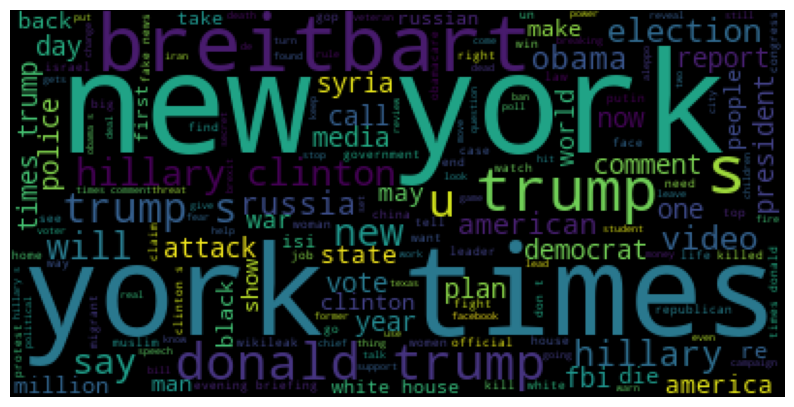

In [38]:
# create variable based on 'title' attribute
!pip install wordcloud matplotlib
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# create variable based on 'title' attribute
title = df_clean.title

# title treatment
## concatenate words
all_title = ' '.join(s for s in title)

# create variable with list of stopwords
stopwords = set(STOPWORDS)

# instantiate wordcloud
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='black').generate(all_title)

# print image with result
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

# print WordCloud
plt.imshow(wordcloud)

# save generated image
wordcloud.to_file('news_titles_wordcloud.png')



In [42]:
# print total words used to create cloud
print('Total words used: {}'.format(len(all_title)))

Total words used: 1522056


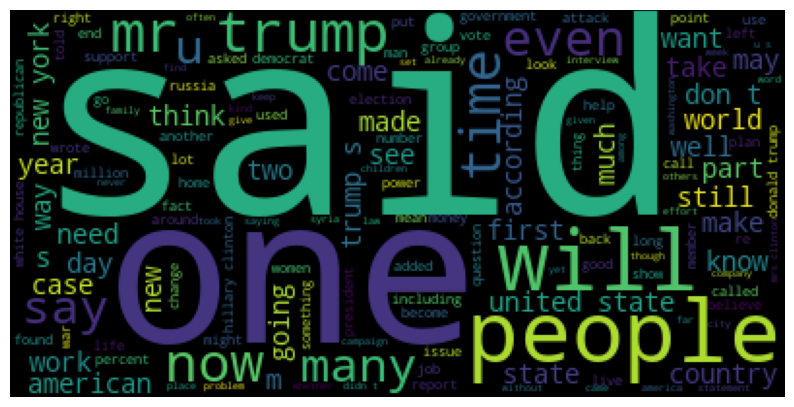

In [44]:
# create variable based on 'text' attribute
text = df_clean.text

# text treatment
## concatenate words
all_text = ' '.join(s for s in text)

# create variable with list of stopwords
stopwords = set(STOPWORDS)

# instantiate wordcloud
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='black').generate(all_text)

# print image with result
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

# print WordCloud
plt.imshow(wordcloud)

# save generated image
wordcloud.to_file('news_titles_wordcloud.png')

In [46]:
# print total words used to create cloud
print('Total words used: {}'.format(len(all_text)))

Total words used: 97449932


In [48]:
# check number of unique entries
print('This set has {} different authors.'.format(len(df_clean.author.unique())))

This set has 3804 different authors.


In [50]:
best_authors = df_clean.author.value_counts()[:10]

print(best_authors)

author
pam  key                 243
admin                    216
jerome  hudson           166
charlie  spiering        141
john  hayward            140
katherine  rodriguez     124
warner  todd  huston     122
ian  hanchett            119
breitbart  news          118
daniel  nussbaum         112
Name: count, dtype: int64


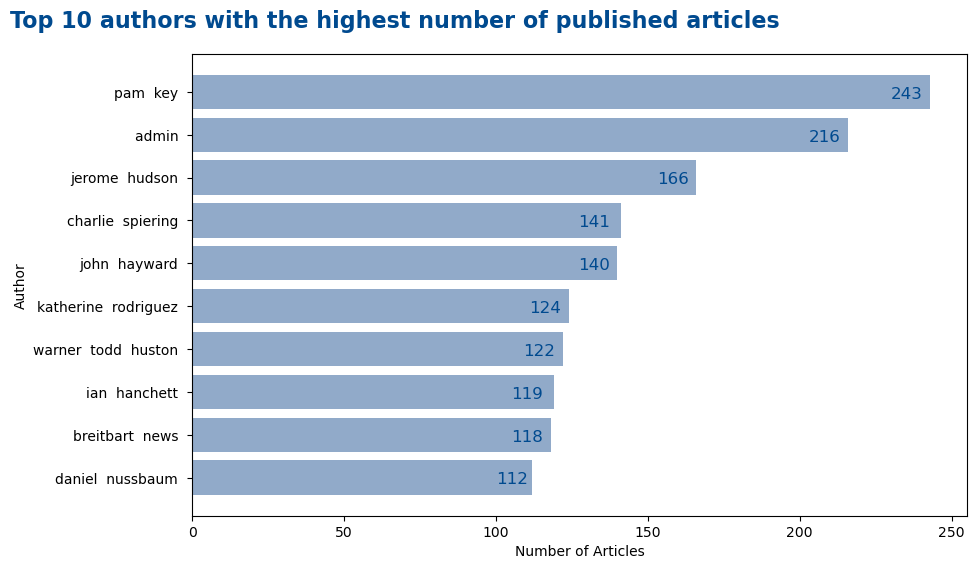

In [52]:
# extract names of authors and the number of articles published
authors = best_authors.index
article_counts = best_authors.values

# create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(authors, article_counts, color='#91aac9')
ax.set_xlabel('Number of Articles')
ax.set_ylabel('Author')

# title
ax.text(-60, -1.5, 'Top 10 authors with the highest number of published articles', fontsize=16, color='#004a8f',
        fontweight='bold')

# number of articles per author
## pam key
ax.text(230, 0.15, '243', fontsize=12, color='#004a8f')

## admin
ax.text(203, 1.15, '216', fontsize=12, color='#004a8f')

## jerome  hudson
ax.text(153, 2.15, '166', fontsize=12, color='#004a8f')

## charlie  spiering
ax.text(127, 3.15, '141', fontsize=12, color='#004a8f')

## john  hayward
ax.text(127, 4.15, '140', fontsize=12, color='#004a8f')

## katherine  rodriguez
ax.text(111, 5.15, '124', fontsize=12, color='#004a8f')

## warner  todd  huston
ax.text(109, 6.15, '122', fontsize=12, color='#004a8f')

## ian  hanchett
ax.text(105, 7.15, '119', fontsize=12, color='#004a8f')

## breitbart  news
ax.text(105, 8.15, '118', fontsize=12, color='#004a8f')

## daniel  nussbaum
ax.text(100, 9.15, '112', fontsize=12, color='#004a8f')

plt.gca().invert_yaxis()  # Invert the y-axis so that the author with the most articles is at the top
plt.show()

In [58]:
!pip install scikit-learn
from sklearn.model_selection import train_test_split

# split training, testing and validation data
## stratify= df_clean.label (to split so that classes have the same proportion)
## random_state so that the result is replicable
train, df_temp = train_test_split(df_clean, test_size=0.25, stratify=df_clean.label, shuffle=True, random_state=123)
validation, test = train_test_split(df_temp, test_size=0.5, stratify=df_temp.label, shuffle=True, random_state=123)

# check set sizes
print('The training set has \t{} records'.format(train.shape[0]))
print('The testing set has \t{} records'.format(test.shape[0]))
print('The validation set has \t{} records'.format(validation.shape[0]))



The training set has 	13285 records
The testing set has 	2215 records
The validation set has 	2214 records


In [62]:
!pip install tensorflow numpy
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# settings
vocab_size = 10000  # maximum number of tokenized words
trunc_type = 'post' # set truncate
pad_type = 'post'   # set padding
oov_tok = '<OOV>'   # default token for out-of-vocabulary tokenization

# tokenize training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train.text)

# store the training data index in a variable
word_index = tokenizer.word_index

# apply tokenizing and padding
training_sequences = tokenizer.texts_to_sequences(np.array(train.text))
training_padded = pad_sequences(training_sequences,
                                truncating=trunc_type,
                                padding=pad_type)

# set maximum padding length
max_length = len(training_padded[0])

# encode the string of validation data
validation_sequences = tokenizer.texts_to_sequences(np.array(validation.text))

# apply padding to validation data
validation_padded = pad_sequences(validation_sequences,
                                  padding=pad_type,
                                  truncating=trunc_type,
                                  maxlen=max_length)

# create arrays with inputs
x_train = np.copy(training_padded)
x_val = np.copy(validation_padded)
y_train = train['label'].values
y_val = validation['label'].values


In [64]:
# check the type of variable 'word_index'
print('The variable "word_index" is of type: {}'.format(type(word_index)))

# visualizar os primeiros 10 pares chave-valor de 'word_index'
print('\nFirst 10 entries in "word_index":')
for word, index in list(word_index.items())[:10]:
    print(word, index)

The variable "word_index" is of type: <class 'dict'>

First 10 entries in "word_index":
<OOV> 1
the 2
to 3
of 4
and 5
a 6
in 7
that 8
is 9
for 10


In [66]:
# find value of key 'york'
value = word_index.get('york', 'word not found')
print('The calue of "york" is: {}'.format(value))

The calue of "york" is: 178


In [68]:
# check the type of variable 'training_sequences' and 'training_padded_
print('The variable "training_sequences" is of type: {}'.format(type(training_sequences)))
print('The variable  "training_sequences" is of type: {}'.format(type(training_padded)))

The variable "training_sequences" is of type: <class 'list'>
The variable  "training_sequences" is of type: <class 'numpy.ndarray'>


In [70]:
# 'training_sequences' sample
training_sequences[:2]

[[2,
  1610,
  1,
  201,
  6,
  1,
  10,
  2,
  113,
  8033,
  31,
  22,
  50,
  1622,
  10,
  6,
  187,
  81,
  5,
  40,
  42,
  24,
  2,
  229,
  3,
  1958,
  57,
  2,
  126,
  4,
  3186,
  543,
  1,
  151,
  2,
  472,
  2919,
  368,
  1,
  9,
  11,
  59,
  124,
  114,
  83,
  4,
  71,
  7,
  2,
  1685,
  141,
  5,
  585,
  98,
  1471,
  4,
  79,
  1167,
  20,
  5765,
  6,
  292,
  3195,
  1,
  4,
  2964,
  8,
  3313,
  30,
  122,
  9,
  2748,
  3,
  2,
  135,
  126,
  7,
  497,
  6357,
  1807,
  4,
  1,
  551,
  9,
  1601,
  71,
  53,
  26,
  3,
  115,
  194,
  1,
  5,
  13,
  325,
  11,
  21,
  527,
  152,
  43,
  144,
  1905,
  3,
  80,
  537,
  54,
  1183,
  61,
  6,
  3295,
  6606,
  122,
  493,
  7119,
  25,
  2,
  358,
  151,
  13,
  2,
  724,
  1085,
  1868,
  440,
  46,
  40,
  523,
  2,
  137,
  7,
  29,
  137,
  117,
  8,
  49,
  22,
  1972,
  373,
  756,
  1102,
  1417,
  3489,
  2,
  1,
  4,
  122,
  8,
  515,
  3,
  136,
  706,
  27,
  84,
  374,
  2,
  51,
  6,
  565,


In [72]:
# 'training_padded' sample
training_padded[:3]

array([[   2, 1610,    1, ...,    0,    0,    0],
       [1579,    1,  323, ...,    0,    0,    0],
       [   6, 3950,  273, ...,    0,    0,    0]])

In [74]:
# check dimension of variable 'training_padded'
print('Dimension fo variable "training_padded":{}'.format(training_padded.shape))

Dimension fo variable "training_padded":(13285, 24195)


In [77]:
print('Number of Records')
print('Training Data: \t',len(x_train))
print('Target Variable:', len(y_train))

Number of Records
Training Data: 	 13285
Target Variable: 13285


In [81]:
!pip install tensorflow

In [83]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# construction of binary classification neural network model
model = tf.keras.Sequential([ 
    # Create embedding layer to give close values to tokens that are similar
    tf.keras.layers.Embedding(vocab_size, 155), 
    # Create convolution layer for batch learning to better identify features
    tf.keras.layers.Conv1D(16, 5, activation='relu'), 
    # Create global pooling layer to return only the maximum value of each batch to further emphasize characteristics
    tf.keras.layers.GlobalMaxPooling1D(), 
    # Create dense layer with one unit and apply activation by sigmoidal function
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

# compile the model
model.compile(loss='binary_crossentropy', # Define the loss function
              optimizer=Adam(learning_rate=0.001), # Set optimizer and learning rate
              metrics=['accuracy', 'Recall', 'Precision', 'FalseNegatives']) # Define metrics for model evaluation during training and testing


In [85]:
# train the model
## verbose=2 to show one message by epoch
## epochs=4 defines the number of epochs that the model will go through the entire training set
history = model.fit(x_train, y_train, verbose = 2, epochs = 4,
                    validation_data = (x_val, y_val), # validation data
                    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]) # stop training when there is no improvement in 'val_loss' for 3 consecutive epochs

Epoch 1/4
416/416 - 801s - 2s/step - FalseNegatives: 752.0000 - Precision: 0.9206 - Recall: 0.8637 - accuracy: 0.9125 - loss: 0.1992 - val_FalseNegatives: 17.0000 - val_Precision: 0.9720 - val_Recall: 0.9815 - val_accuracy: 0.9806 - val_loss: 0.0607
Epoch 2/4
416/416 - 1020s - 2s/step - FalseNegatives: 60.0000 - Precision: 0.9836 - Recall: 0.9891 - accuracy: 0.9886 - loss: 0.0371 - val_FalseNegatives: 19.0000 - val_Precision: 0.9858 - val_Recall: 0.9793 - val_accuracy: 0.9855 - val_loss: 0.0375
Epoch 3/4
416/416 - 1031s - 2s/step - FalseNegatives: 6.0000 - Precision: 0.9978 - Recall: 0.9989 - accuracy: 0.9986 - loss: 0.0097 - val_FalseNegatives: 15.0000 - val_Precision: 0.9858 - val_Recall: 0.9837 - val_accuracy: 0.9874 - val_loss: 0.0315
Epoch 4/4
416/416 - 939s - 2s/step - FalseNegatives: 1.0000 - Precision: 0.9998 - Recall: 0.9998 - accuracy: 0.9998 - loss: 0.0029 - val_FalseNegatives: 16.0000 - val_Precision: 0.9847 - val_Recall: 0.9826 - val_accuracy: 0.9864 - val_loss: 0.0306


In [87]:
# print model
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 24195, 155)     │     1,550,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24191, 16)      │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,687,301 (17.88 MB)

 Trainable params: 1,562,433 (5.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,124,868 (11.92 MB)

None


In [89]:
# create function to plot the results
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.xticks(ticks=history.epoch)
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.title(string.upper() + ' vs. Epochs')
  plt.show()

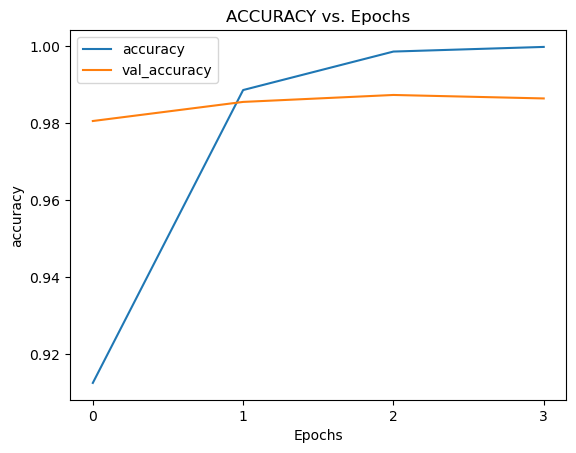

In [91]:
plot_graphs(history, 'accuracy')

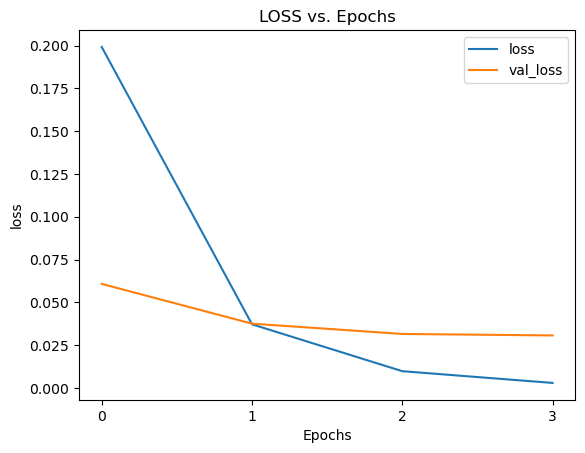

In [93]:
# plot loss graph
plot_graphs(history, 'loss')

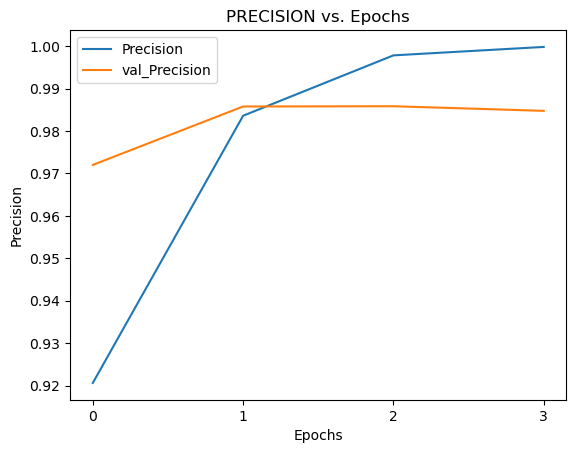

In [99]:
# plot precision graph
plot_graphs(history, 'Precision')

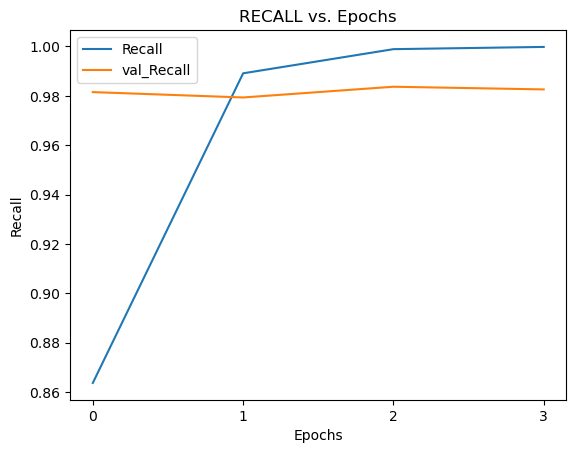

In [101]:
# plot recall graph
plot_graphs(history, 'Recall')


In [109]:
print(history.history.keys())

dict_keys(['FalseNegatives', 'Precision', 'Recall', 'accuracy', 'loss', 'val_FalseNegatives', 'val_Precision', 'val_Recall', 'val_accuracy', 'val_loss'])


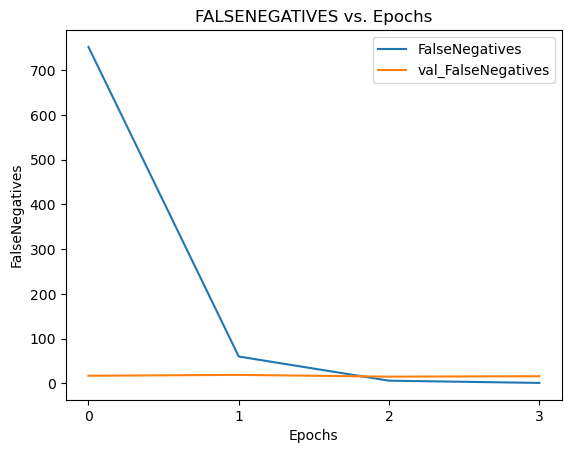

In [111]:
# plot false negative graph
plot_graphs(history, 'FalseNegatives')

In [113]:
# handle test data
test_sequences = tokenizer.texts_to_sequences(np.array(test.text))
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen = max_length)

In [115]:
# make predictions
preds = np.round(model.predict(test_padded))

70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step


In [117]:
# check number of expected records
print('Number of records in the test set:  \t {}'.format(test.shape[0]))
print('Number of predictions made by the model: {}'.format(len(preds)))

Number of records in the test set:  	 2215
Number of predictions made by the model: 2215


In [121]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

# calculate evaluation metrics
## accuracy
accuracy = accuracy_score(test['label'].values, preds)
print('Accuracy: \t{:.4f}'.format(accuracy))

## recall
recall = recall_score(test['label'].values, preds)
print('Recall: \t{:.4f}'.format(recall))

## precision
precision = precision_score(test['label'].values, preds)
print('Precision: \t{:.4f}'.format(precision))


Accuracy: 	0.9833
Recall: 	0.9783
Precision: 	0.9815


In [143]:
!pip install scikit-plot


70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step
                    Assessment Metrics Report                    
-----------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9846    0.9869    0.9857      1295
           1     0.9815    0.9783    0.9799       920

    accuracy                         0.9833      2215
   macro avg     0.9830    0.9826    0.9828      2215
weighted avg     0.9833    0.9833    0.9833      2215

---------------


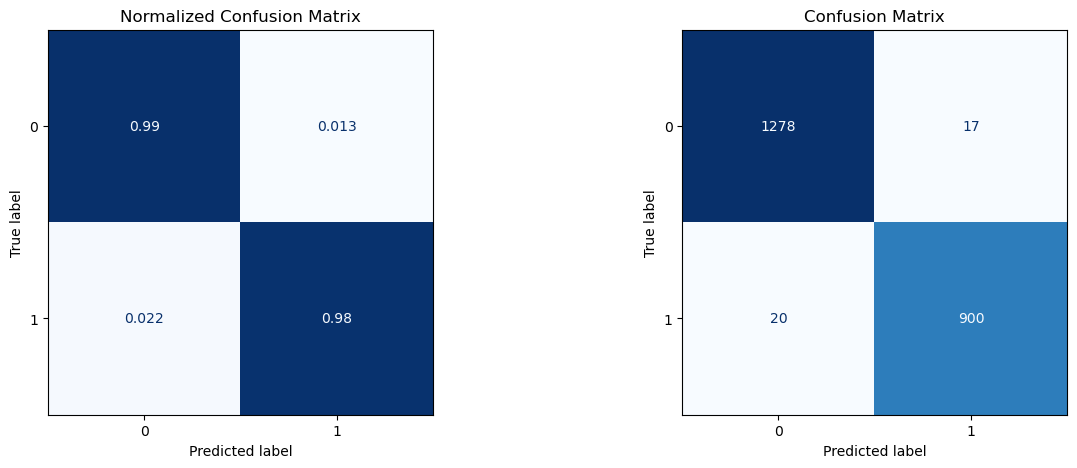

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Save predicted data to a variable
y_pred = np.round(model.predict(test_padded)).astype(int).flatten()

# Print assessment metrics report
print('Assessment Metrics Report'.center(65) + ('\n') + ('-' * 65))
print(classification_report(test['label'], y_pred, digits=4) + ('\n') + ('-' * 15))

# Compute confusion matrix
cm = confusion_matrix(test['label'], y_pred)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

# Plot confusion matrix
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot normalized confusion matrix
ConfusionMatrixDisplay(cm_normalized).plot(ax=ax[0], cmap='Blues', colorbar=False)
ax[0].set_title('Normalized Confusion Matrix')

# Plot confusion matrix
ConfusionMatrixDisplay(cm).plot(ax=ax[1], cmap='Blues', colorbar=False)
ax[1].set_title('Confusion Matrix')

plt.show()


In [149]:
# save training and validation data predictions in variables
y_pred_train = np.round(model.predict(x_train))
y_pred_val = np.round(model.predict(x_val))

416/416 ━━━━━━━━━━━━━━━━━━━━ 100s 237ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step


In [151]:
# print training data evaluation metrics report
print('Evaluation Metrics Report - Training Data'.center(65) + ('\n') + ('-' * 65))
print(classification_report(train['label'], y_pred_train, digits=4) + ('\n') + ('-' * 65))

# print validation data evaluation metrics report
print('Evaluation Metrics Report - Validation Data'.center(65) + ('\n') + ('-' * 65))
print(classification_report(validation['label'], y_pred_val, digits=4) + ('\n') + ('-' * 65))

# print test data evaluation metrics report
print('Evaluation Metrics Report - Test Data'.center(65) + ('\n') + ('-' * 65))
print(classification_report(test['label'], y_pred, digits=4) + ('\n') + ('-' * 65))

            Evaluation Metrics Report - Training Data            
-----------------------------------------------------------------
              precision    recall  f1-score   support

           0     1.0000    0.9997    0.9999      7766
           1     0.9996    1.0000    0.9998      5519

    accuracy                         0.9998     13285
   macro avg     0.9998    0.9999    0.9998     13285
weighted avg     0.9998    0.9998    0.9998     13285

-----------------------------------------------------------------
           Evaluation Metrics Report - Validation Data           
-----------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9877    0.9892    0.9884      1294
           1     0.9847    0.9826    0.9837       920

    accuracy                         0.9864      2214
   macro avg     0.9862    0.9859    0.9860      2214
weighted avg     0.9864    0.9864    0.9864      2214

----------------

In [157]:
# save the model as TensorFlow
fakenews_classifier = model.save('fakenews_cfl.keras')

# save model weights
# classifier_fakenews_weights = model.save_weights('clFakeNews_weights.tf')
